# Statistical Learning - Tree Based Methods

---

## Contents

### [The Basics of Decision Trees](#basics)
   - [Regression Trees](#regression-trees)
   - [Classification Trees](#classification-trees)
   

### [Bagging, Random Forests, Boosting](#bagging-boosting)
   - [Bagging](#bagging)
   - [Random Forests](#random-forests)
   - [Boosting](#boosting)
   

### [Lab](#lab)

---

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as mpe
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

np.set_printoptions(suppress=True)
%matplotlib inline
#plt.style.use("fivethirtyeight")

---

## Utilities

In [2]:
def plot_regr_tree_regions(X1, X2, model, figsize = (8, 4)):
    fig, ax = plt.subplots(figsize = figsize)
    x_min, x_max = np.array(X1).min() - 1, np.array(X1).max() + 1
    y_min, y_max = np.array(X2).min() - 10, np.array(X2).max() + 10
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    plt.tight_layout(h_pad = 0.5, w_pad = 0.5, pad = 2.5)
    z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap = "Spectral", alpha = 0.5)
    sns.scatterplot(x = np.array(X1), y = np.array(X2),
                    color = "gainsboro", edgecolor = "k",
                    linewidth = 0.8, s = 75, ax = ax)
    plt.grid(False)
    plt.show()

---

## Datasets

In [3]:
hit = pd.read_csv("data/hitters.csv").dropna()
hit.drop("Unnamed: 0", axis = 1, inplace = True)
hit.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [4]:
hea = pd.read_csv("data/heart.csv").dropna()
hea.drop("Unnamed: 0", axis = 1, inplace = True)
hea.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


---

<a id="basics"></a>
# The Basics of Decision Trees

I *decision tree* sono dei *learning method* capaci di risolvere problemi di regressione e classificazione che si basano su un concetto di *stratificazione* o *segmentazione* del *predictor space* in regioni distinte. Per realizzare la *predict* di una certa osservazione, utilizzano la media o la moda delle *response* delle osservazioni di *training* che appartengono alla regione in cui ricade l'osservazione di test.

---

<a id="regression-trees"></a>
## Regression Trees

Utilizzeremo il dataset *Hitters* per predire il *Salary* di un giocatore di baseball in base al numero di *Years* che ha giocato in campionato e il numero di *Hits* realizzati nell'anno precedente.

In [5]:
features = ["Years", "Hits"]
response = "Salary"

X = hit[features].copy()
Y = np.log(hit[response]).copy()

model = DecisionTreeRegressor(max_leaf_nodes = 3)
model.fit(X, Y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=3,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

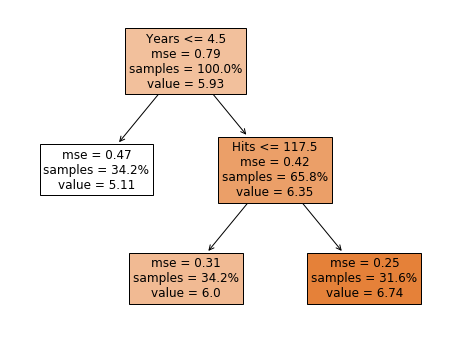

In [6]:
fig, ax = plt.subplots(figsize = (8, 6))
__ = plot_tree(decision_tree = model, feature_names = features,
               filled = True, proportion = True, precision = 2,
               fontsize = 12, ax = ax)

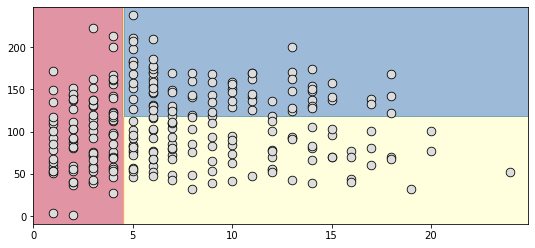

In [7]:
plot_regr_tree_regions(X1 = X.Years, X2 = X.Hits, model = model)

Il *top split* assegna i giocatori con meno di 4.5 anni al branch sinistro. Da notare come il valore di soglia sia sempre il punto medio fra due valori contigui, così da non creare ambiguità (la colonna *Years* è un array di interi, quindi non ha senso parlare di 4.5 anni).

Il salary predetto per questi giocatori sarà il valore medio della *response* per le osservazioni in quella regione, cioè circa 165K dollari.

In [8]:
X_test = pd.DataFrame({"Years": [3], "Hits": [10]})
np.exp(model.predict(X_test))

array([165.1393406])

I giocatori con almeno 5 anni vanno nel branch destro, e sono suddivisi nuovamente in base ad *Hits*.

L'albero produce tre regioni, anche dette **terminal nodes** o **leaves**, quindi è capace di restituire tre diversi valori di *Salary*.

I punti dell'albero in cui il *predictor space* è splittato in due prendono il nome di **internal nodes**. I segmenti dell'albero che connettono i nodi sono detti **branches**.

Possiamo sicuramente affermare che *Years* è il fattore determinante nella predizione di *Salary*, e che i giocatori con meno esperienza guadagnano di meno di quelli più anziani. Per i giocatori con meno esperienza, entra in gioco *Hits*.

<br>

Per costruire un *regression tree* sono necessari due step:
- Dividere il *predictor space* in $J$ regioni distinte e non sovrapposte $R_1,\dots,R_J$.


- Per ogni osservazione che ricade nella regione $R_j$ si restituisce la stessa *prediction*, cioè la media della *response* di tutte le osservazioni di *training* associate alla regione $R_j$.

Teoricamente, le regioni potrebbero assumere qualsiasi forma, ma per semplicità di interpretazione dei risultati è stato scelto di dividere il *predictor space* in rettangoli o *boxes*. L'obiettivo, quindi, è individuare i *box* $R_1,\dots,R_j$ che minimizzano una *RSS* così definita:

$$\large minimize\; RSS=\sum_{j=1}^{J}\sum_{i\in R_j}(y_i-\hat{y}_{R_j})^2$$

Dove $\hat{y}_{R_j}$ è il valor medio della *response* per le osservazioni di *training* nella regione $R_j$.

Sfortunatamente non è possibile considerare ogni possibile partizione del *feature space*, perciò si è scelto di seguire un approccio *top-down* e *greedy* che prende il nome di **recursive binary splitting**.

L'approccio è *top-down* perché inizia la propria analisi dalla cima dell'albero, dove tutte le osservazioni appartengono ad un'unica regione fittizia; è *greedy* perché la decisione riguardo un singolo *split* si basa solo sulle informazioni a disposizione nel momento in cui è calcolato, e non sui risultati delle proiezioni future che lo *split* in questione potrebbe causare.

Per realizzare il *recursive binary splitting* è necessario individuare il predittore $X_j$ ed il **cutpoint** $s$ per i quali lo split del *predictor space* nelle regioni $\{X|X_j<s\}$ e $\{X|X_j\geq s\}$ porta alla maggiore riduzione possibile di *RSS*.

In altre parole, si considerano tutti i predittori $X_1,\dots,X_p$ e tutti i valori possibili del *cutpoint* $s$ per ciascuno di essi, andando poi a scegliere il predittore ed il *cutpoint* capaci di produrre un albero con il più basso valore di *RSS*.

A livello matematico, per ciascun valore di $j$ ed $s$ possiamo definire i seguenti semi-piani:

$$\large R_1(j,s)=\{X|X_j<s\}\;\;\;R_2(j,s)=\{X|X_j\geq s\}$$

E si cercano i valori di $j$ ed $s$ che minimizzano la seguente equazione:

$$\large minimize\; \sum_{i:x_i\in R_1(j,s)}(y_i-\hat{y}_{R_1})^2+
\sum_{i:x_i\in R_2(j,s)}(y_i-\hat{y}_{R_2})^2$$

Il processo si ripete cercando il miglior predittore ed il miglior *cutpoint* capaci di splittare ulteriormente i dati per minimizzare la *RSS* delle regioni risultati. La differenza è che, nel secondo step, al posto di splittare l'intero *predictor space* si splitta una delle regioni precedentemente identificate, così da avere in totale tre regioni. Il ciclo continua nel tentativo di splittare ulteriormente una di queste tre regioni, fin quando non si raggiunge un qualche *stopping criterion* definito a priori.

<br>

Il *recursive binary splitting* è un algoritmo che ci permette di addestrare un modello con buone *predictions* sul *training set*, ma che molto probabilmente soffrirà di *overfitting* e peformerà male sui dati di test.

La soluzione più efficiente per risolvere il problema consiste nell'applicare un secondo algoritmo, il **cost complexity pruning** (anche detto *weakest link pruning*) sull'albero restituito dal *recursive binary splitting*.

Il processo di *pruning* si basa sull'assunto secondo il quale è possibile che un albero più piccolo di quello costruito dal *RBS*, cioè caratterizzato da un numero inferiore di regioni e quindi di *splits*, possa presentare molta meno varianza e solo una minima differenza di bias, riuscendo così a fornire risultati migliori sui dati di test.

Al posto di considerare tutti i possibili sotto-alberi ricavabili dall'albero generale, si introduce un **tuning parameter** $\alpha$ che modifica il problema di minimizzazione come segue:

$$\large \sum_{m=1}^{n_T}\sum_{i:x_i\in R_{m}}(y_i-\hat{y}_{R_m})^2+
\alpha\cdot n_T$$

Semplifichiamo: a partire dall'albero totale $T_{tot}$ posso estrarre diversi alberi $T$ che contengono un numero di foglie (e quindi di regioni) pari a $n_T$; ogni regione sarà associata ad un suo valore di *RSS*, come evidenziato dalla seconda sommatoria, ma il calcolo di quest'ultima conterrà una penalità pari al *tuning parameter* moltiplicato per il numero di foglie dell'albero.

In altre parole, per ogni possibile valore di $\alpha$ (che è sempre positivo), esisterà sempre un sotto-albero dell'albero totale che minimizza la precedente equazione; questo vuol dire che ci sarà un rapporto 1:1 fra i valori di $\alpha$ e il sotto-albero che minimizza il problema.

Il *tuning parameter* controlla il *trade-off* fra la complessità del sotto-albero (cioè il suo numero di foglie) e la capacità di quest'ultimo di *fittare* i dati di *training*. Se $\alpha=0$, si ottiene nuovamente l'albero generale perché è come se non ci sia alcuna penalità per restituire un albero con tante foglie.

Il valore di $\alpha$ può essere ricavato con la *cross-validation*!

---

<a id="classification-trees"></a>
## Classification Trees

Un *classification tree* è molto simile ad un *regression tree*, ma la *prediction* restituita per la generica osservazione non è più la *response media*, bensì la *most occurring class* della regione in cui essa ricade.

Così come per la recressione, si utilizza il *recursive binary splitting* per costruire l'albero con approccio *top-down*, ma la metrica di riferimento per il problema di minimizzazione non è più la *RSS* ma l'*error rate*, cioè la frazione di osservazioni della regione in questione che non appartengono alla *most common class*.

Da un punto di vista più matematico:

$$\large Error\;Rate=1-max_{k}(\hat{p}_{mk})$$

Il valore di $\hat{p}_{mk}$ è la proporzione di osservazioni della regione $m$ che appartengono alla classe $k$. E' stato dimostrato, però, che l'*error rate* non è particolarmente adatto alla costruzione dell'albero, pertanto si è soliti fare riferimento ad altre due metriche: il *gini index* e l'*entropy*.

Il **gini index** è definito come segue:

$$\large G=\sum_{k=1}^{K}\hat{p}_{mk}(1-\hat{p}_{mk})$$

Questa metrica può essere calcolata in qualunque nodo dell'albero, anche alla sua radice, e rappresenta una sorta di misurazione della variabilità totale di tutte le $K$ classi. Possiamo notare come il *gini* assuma valori più bassi se tutte le proporzioni $\hat{p}_{mk}$ sono vicine a zero o ad uno; per questo motivo si dice che il *gini* è in realtà una misura di **purity** del nodo. Valori bassi di *gini* indicano che il nodo in questione contiene prevalentemente osservazioni di una sola classe e quindi è più puro.

Un'alternativa al *gini index* è l'**entropy**:

$$\large D=-\sum_{k=1}^{K}\hat{p}_{mk}log\hat{p}_{mk}$$

Dato che tutte le proporzioni sono nativamente comprese in $[0, 1]$, si nota come la quantità $-\hat{p}_{mk}log\hat{p}_{mk}$ sia sempre positiva. Inoltre, così come per il *gini*, l'entropia assume valori minimi se tutte le proporzioni sono vicine a zero o ad uno.

Facciamo un esempio con il dataset *Heart*, provando a predire *HD* (*heart disease*):

In [9]:
df = hea.copy()
df.ChestPain = pd.factorize(df.ChestPain)[0]
df.Thal = pd.factorize(df.Thal)[0]

X = df.drop("AHD", axis = 1)
Y, class_names = pd.factorize(df.AHD)

model = DecisionTreeClassifier(
    max_depth = None,
    max_leaf_nodes = 6,
    max_features = None)
model.fit(X, Y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

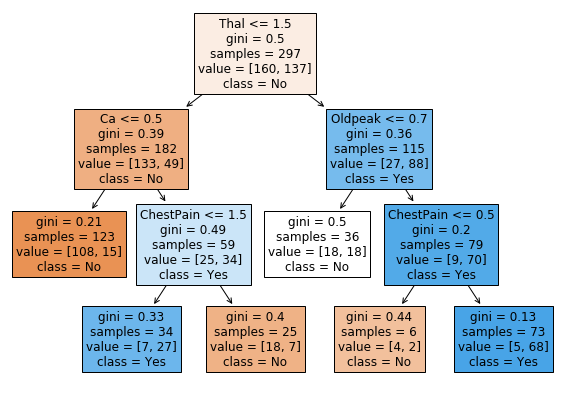

In [10]:
fig, ax = plt.subplots(figsize = (10, 7))
__ = plot_tree(decision_tree = model, feature_names = X.columns,
               class_names = class_names, filled = True,
               proportion = False, precision = 2,
               fontsize = 12, ax = ax)

---

<a id="bagging-boosting"></a>
# Bagging, Random Forests, Boosting

---

<a id="bagging"></a>
## Bagging

Il *learning method* che porta alla costruzione dei *decision tree* è nativamente caratterizzato da alta varianza, cioè tende a produrre modelli molto diversi in corrispondenza di piccole variazioni del *training set*.

Il **bagging**, anche detto **bootstrap aggregating**, è una tecnica ideata per ridurre la varianza di un metodo di *statistical learning* che funziona particolarmente bene sui *decision tree*.

L'idea di fondo consiste nell'estrarre tanti *training set* dalla popolazione e addestrare un modello per ciascuno di essi, con l'idea di restituire come *prediction* finale la media delle *predict* dei singoli modelli.

$$\large \hat{f}_{avg}(x)=\frac{1}{B}\sum_{b=1}^{B}\hat{f}^b(x)$$

All'atto pratico, però, è impossibile estrarre più *training set* dalla popolazione, ed è quindi necessario ricorrere al *bootstrapping*: i singoli modelli saranno addestrati a partire da $B$ *bootstrapped dataset* e la *prediction* finale sarà la media delle loro singole *predict*.

Nell'ambito dei *decision tree*, il procedimento non cambia: si costruiscono $B$ alberi usando $B$ *bootstrapped datasets* e ne si calcola il valore medio delle *predictions*. Specifichiamo che gli alberi che alimentano il *bagging* non subiscono alcun *pruning*, pertanto ognuno di essi sarà caratterizzato da altissima varianza e bias minimo.

Per quanto riguarda i *classification tree*, la *prediction* finale si basa sul **majority vote**: la classe restituita è quella che ricorre più spesso nelle *predict* dei singoli alberi.

E' bene sottolineare che il numero di alberi $B$ che costituiscono un modello di *bagging* non risulta essere un iperparametro critico per le performance del modello. In altre parole, scegliere $B$ molto alto non porta all'*overfitting*: basta cercare un valore tale da offrire buone performance sui dati di test.

<br>

In realtà esiste un metodo molto semplice per stimare il *test error* di un modello di *bagging* senza dover usare la *cross-validation*.

E' possibile dimostrare, infatti, che ogni singolo albero è alimentato da circa $2/3$ delle osservazioni del *training set* originale; il rimanente $1/3$ prende il nome di **out-of-bag** *dataset*. Potremmo predire la *response* della $i$-esima osservazione utilizzando tutti gli alberi in cui quella precisa osservazione era in *OOB*. Questo approccio dovrebbe garantirci circa $B/3$ *predict* per l'osservazione $i$-esima!

In questa maniera siamo in grado di calcolare un *OOB MSE* o un *OOB Error Rate* in base al task in analisi e usarlo come stima del *test error* del modello.

<br>

Uno svantaggio importante di un modello di *bagging* è la perdità di interpretabilità del modello, specialmente nel caso dei *decision tree*.

Ciò che offrono i modelli *bagged*, però, è la descrizione delle **variable importances**, una sorta di *ranking* dei predittori basato su quanto ciascuno di essi sia in grado di spiegare la variabilità della *response*. In particolare, per i *regression tree* si tiene traccia della decrescita di *RSS* dovuta agli split guidati da ciascun predittore, normalizzando in seguito per il numero di alberi $B$ del modello *bagged*; un alto valore di questa metrica indica un predittore fondamentale nella *prediction*. In maniera simile, nei *classification tree* si tiene traccia della decrescita di *gini index* dovuta agli split guidati da ciascun predittore, normalizzando sempre per il numero di alberi $B$.

---

<a id="random-forests"></a>
## Random Forests

Il *learning method* comunemente chiamato *random forest* segue lo stesso procedimento dei *bagged trees*, ma apporta una sostanziale differenza nella costruzione dei *decision tree*. Nel momento in cui si deve calcolare un qualsiasi split, si estraggono randomicamente $m$ elementi dall'insieme dei $p$ predittori totali e solo uno di essi può essere utilizzato per guidare lo split.

Perché forzare l'algoritmo a non considerare gran parte dei predittori per realizzare uno split? E' possibile osservare che, nella maggior parte degli alberi di un modello di *bagged trees*, gli alberi tendono ad utilizzare il predittore più forte come radice dell'albero; così facendo, gli alberi risultanti saranno tutti molto simili tra loro, e quindi le loro *predictions* saranno altamente correlato. Calcolare una media di valori altamente correlati impedisce che ci sia un forte crollo della varianza, che è l'obiettivo primario del processo di *bagging*.

In genere, nelle *random forest* si fissa $m\approx \sqrt{p}$. Inoltre, come per i *bagged trees*, il numero di alberi $B$ non rappresenta un iperparametro critico: basta scegliere un valore che garantisca un buon valore di *test error*.

---

<a id="boosting"></a>
## Boosting

Il *boosting*, come il *bagging*, è una tecnica generalizzata che può essere applicata a una gran varietà di *statistical learning methods*, sia di classificazione che di regressione. In questo caso presentiamo solo l'applicazione del *boosting* ai *decision tree*.

Anche nel *boosting* è necessario costruire una serie di alberi distinti, ma nel *bagging* questi sono costruiti indipendentemente dagli altri, ognuno sulla base di un proprio *bootstrapped dataset*.

Nel *boosting*, invece, gli alberi sono costruiti in sequenza: ogni albero si basa sulle informazioni dell'albero che è stato costruito allo step precedente.

Presentiamo il procedimento in forma algoritmica per poi approfondirne i dettagli:
- Sia $\hat{f}=0$ e di conseguenza $resid_{i}=y_i$


- Per $b=1,\dots,B$, ripetere i seguenti step:
   - Addestrare un albero $\hat{f}^b$ con $d$ split (e quindi $d+1$ nodi/regioni) usando i residui come *response*; il *training set*, quindi, è $(X,resid)$.
<br><br>
   - Aggiornare il modello finale $\hat{f}$ aggiungendo ad esso il contributo di una versione ridotta dell'albero appena costruito:
$$\large \hat{f}(x)\leftarrow\;\hat{f}(x)+\lambda \hat{f}^b(x)$$
<br><br>

- Aggiornare i residui:
$$\large resid_i\leftarrow \; resid_i-\lambda\hat{f}^b(x_i)$$
<br><br>

- Restituire il *boosted model*:
$$\large \hat{f}(x)=\sum_{b=1}^{B}\lambda \hat{f}^b(x)$$

Gli alberi utilizzati possano essere anche molto piccoli; è stato dimostrato che anche con $d=1$ (uno split, due foglie) l'algoritmo funziona molto bene. In tal caso, non si parla di un vero e proprio albero ma di un cosiddetto **stump**.

Addestrando degli alberi molto piccoli si migliora lentamente $\hat{f}$ nelle regioni in cui non performa molto bene. La velocità del processo è guidata dallo **shrinkage parameter** $\lambda$: si tratta di un piccolo numero positivo, tipicamente fissato pari a $0.01$ o $0.001$ (in realtà dipende dal problema), che controlla l'entità della *predict* del generico albero che va a finire nel modello finale. Appare chiaro, inoltre, che con $\lambda$ molto piccolo avremo bisogno di un grande valore di $B$ per raggiungere performance accettabili.

Anche il parametro $d$, cioè l'**interaction depth** ha un ruolo importante: $d$ *splits*, infatti, possono coinvolgere al massimo $d$ predittori, e quindi questo iperparametro ha il compito di controllare la complessità dei singoli alberi intermedi.

---

<a id="lab"></a>
# Lab

Carichiamo il dataset *Boston*:

In [11]:
bost = pd.read_csv("data/boston.csv")

response = "medv"
X = bost.drop(response, axis = 1)
Y = bost[response]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.5,
                                                    random_state = 888)

Usiamo il *bagging* per predire *medv* con tutti i predittori. Da notare il settaggio di *max_features* che trasforma la *random forest* in un *bagged trees*.

In [12]:
model = RandomForestRegressor(max_features = len(X.columns),
                              random_state = 888)
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=13, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=888, verbose=0, warm_start=False)

*MSE* del *bagged trees*:

In [13]:
mean_squared_error(Y_test, model.predict(X_test))

9.12325456521739

DataFrame contenente le *feature importances*:

In [14]:
feats_imp = pd.DataFrame({"importance": model.feature_importances_,
                          "predictor": X.columns})
feats_imp.sort_values("importance", ascending = False, inplace = True)
feats_imp

,importance,predictor
12,0.392572,lstat
5,0.370881,rm
0,0.071208,crim
7,0.065726,dis
4,0.025131,nox
9,0.019113,tax
11,0.016937,black
6,0.015755,age
10,0.009444,ptratio
2,0.006234,indus


<br>

Proviamo con una vera *random forest*. Da notare *max_features* limitato a 6:

In [15]:
model = RandomForestRegressor(max_features = 6, random_state = 888)
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=888, verbose=0, warm_start=False)

Il *MSE* della *random forest* è inferiore, performa meglio sui dati di test!

In [16]:
mean_squared_error(Y_test, model.predict(X_test))

7.931917256916995

Ancora *feature importances*:

In [17]:
feats_imp = pd.DataFrame({"importance": model.feature_importances_,
                          "predictor": X.columns})
feats_imp.sort_values("importance", ascending = False, inplace = True)
feats_imp

,importance,predictor
12,0.352864,lstat
5,0.247413,rm
0,0.095430,crim
7,0.070916,dis
4,0.056749,nox
10,0.043910,ptratio
9,0.036592,tax
2,0.034758,indus
6,0.030275,age
11,0.018666,black


<br>

Proviamo con il *boosting*:

In [18]:
model = GradientBoostingRegressor(n_estimators = 500,
                                  learning_rate = 0.01,
                                  random_state = 888)
model.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=888, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
feats_imp = pd.DataFrame({"importance": model.feature_importances_,
                          "predictor": X.columns})
feats_imp.sort_values("importance", ascending = False, inplace = True)
feats_imp

,importance,predictor
12,0.418302,lstat
5,0.346830,rm
7,0.084569,dis
0,0.062730,crim
10,0.033639,ptratio
9,0.014659,tax
4,0.014230,nox
11,0.010397,black
6,0.006616,age
8,0.005448,rad


In [20]:
mean_squared_error(Y_test, model.predict(X_test))

8.353812213237443

Si può dire che dal punto di vista delle performance è paragonabile alla *RF*, ma andrebbe approfondito con una *CV*.

---